In [1]:
from __future__ import annotations

import json
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from dateutil.parser import isoparse
import numpy as np

# Тесты

In [2]:


class PumpVolumeAnalyzer:
    """
    Расчёт точности определения объёма по датчику rpm1.

    Шаги:
    1.  Для каждого пролива интегрируем rpm1 * dt  →  суммарные обороты N_rev.
    2.  Оцениваем единый калибровочный коэффициент
            k_litre_per_rev = Σ V_fact / Σ N_rev
        (литров на один оборот крыльчатки).
    3.  Пересчитываем слитый объём V_meas = k * N_rev,
        сравниваем с фактом → ошибка.
    """

    def __init__(self, json_path: str | Path) -> None:
        self.path = Path(json_path)
        self._raw = None
        self._df_tests = None  # per-test statistics
        self._df_pwm = None  # per PWM summary
        self.k_litre_per_rev: float | None = None

    # ------------------------------------------------------------------ #
    #                              API                                    #
    # ------------------------------------------------------------------ #

    def run(self) -> "PumpVolumeAnalyzer":
        self._load()
        self._calc_per_test()
        self._calc_per_pwm()
        return self

    @property
    def per_test(self) -> pd.DataFrame:
        """Таблица по каждому проливу."""
        self._require_calc()
        return self._df_tests.copy()

    @property
    def per_pwm(self) -> pd.DataFrame:
        """Сводка ошибок по PWM."""
        self._require_calc()
        return self._df_pwm.copy()

    def overall_mape(self, *, weighted: bool = True) -> float:
        """
        Итоговая MAPE, %.
        weighted=True — вес = фактический объём пролива.
        """
        self._require_calc()
        df = self._df_tests
        if weighted:
            w = df["volume_fact_l"]
            return float((df["err_%"].abs() * w).sum() / w.sum())
        return float(df["err_%"].abs().mean())

    def overall_mae(self, *, weighted: bool = True) -> float:
        """
        Средняя абсолютная ошибка (MAE), литры.
        weighted=True — вес = фактический объём пролива.
        """
        self._require_calc()
        df = self._df_tests
        if weighted:
            w = df["volume_fact_l"]
            return float((df["err_l"].abs() * w).sum() / w.sum())
        return float(df["err_l"].abs().mean())

    def overall_rmse(self, *, weighted: bool = True) -> float:
        """
        Среднеквадратичная ошибка (RMSE), литры.
        weighted=True — вес = фактический объём пролива.
        """
        self._require_calc()
        df = self._df_tests
        if weighted:
            w = df["volume_fact_l"]
            return float(np.sqrt((df["err_l"] ** 2 * w).sum() / w.sum()))
        return float(np.sqrt((df["err_l"] ** 2).mean()))

    def overall_smape(self) -> float:
        """
        Симметричная средняя абсолютная процентная ошибка (SMAPE), %.
        Не имеет взвешённой версии (обычно).
        """
        self._require_calc()
        df = self._df_tests
        denom = (df["volume_fact_l"].abs() + df["volume_meas_l"].abs())
        # Чтобы избежать деления на 0
        smape = 2 * df["err_l"].abs() / denom.replace(0, np.nan)
        return float(smape.mean(skipna=True) * 100)

    # ------------------------------------------------------------------ #
    #                        internal logic                               #
    # ------------------------------------------------------------------ #

    def _load(self) -> None:
        with self.path.open("r", encoding="utf-8") as fh:
            self._raw = json.load(fh)

    def _calc_per_test(self) -> None:
        rows = []
        sum_vol_fact = 0.0
        sum_rev = 0.0

        for idx, test in enumerate(self._raw, start=1):
            pwm = test["samples"][0]["pwm"]

            # --- собираем валидные точки rpm1 & timestamp ---
            samples = [
                (isoparse(s["timestamp"]), s["rpm1"])
                for s in test["samples"]
                if s["rpm1"] != -1
            ]
            if len(samples) < 2:
                continue  # нечего интегрировать

            samples.sort(key=lambda x: x[0])
            t = np.array([s[0].timestamp() for s in samples])  # секунды
            rpm = np.array([s[1] for s in samples], dtype=float)

            # интервалы dt между точками
            dt = np.diff(t)
            duration_s = test["summary"]["duration_msec"] / 1000.0
            dt_last = duration_s - dt.sum()  # «хвост» до конца пролива
            dt = np.append(dt, max(dt_last, 0.0))

            # интеграл оборотов: Σ rpm * dt / 60
            n_rev = float(np.sum(rpm * dt) / 60.0)

            vol_fact = test["summary"]["volume_liters"]
            sum_vol_fact += vol_fact
            sum_rev += n_rev

            rows.append(
                {
                    "test_id": idx,
                    "duration_s": duration_s,
                    "pwm": pwm,
                    "volume_fact_l": vol_fact,
                    "n_rev": n_rev,  # нужно для калибровки
                }
            )

        df = pd.DataFrame(rows)

        # ---------- глобальный коэффициент ----------
        self.k_litre_per_rev = sum_vol_fact / sum_rev

        # ---------- вычисляем измеренный объём и ошибки ----------
        df["volume_meas_l"] = df["n_rev"] * self.k_litre_per_rev
        df["err_l"] = df["volume_meas_l"] - df["volume_fact_l"]
        df["err_%"] = df["err_l"] / df["volume_fact_l"] * 100

        df["flow_fact_lInMin"] = df["volume_fact_l"] / df["duration_s"] * 60
        df["flow_meas_lInMin"] = df["volume_meas_l"] / df["duration_s"] * 60

        self._df_tests = df[
            ["test_id", "duration_s", "pwm", "volume_fact_l", "volume_meas_l", "err_l", "err_%", "flow_fact_lInMin",
             "flow_meas_lInMin", "n_rev"]
        ]

    def _calc_per_pwm(self) -> None:
        grp = self._df_tests.groupby("pwm")
        self._df_pwm = grp.agg(
            n_tests=("test_id", "count"),
            mean_err_l=("err_l", "mean"),
            std_err_l=("err_l", "std"),
            mean_abs_err_l=("err_l", lambda x: x.abs().mean()),
            MAPE_pct=("err_%", lambda x: x.abs().mean()),
            std_err_pct=("err_%", "std"),
        ).reset_index()

    # ------------------------------------------------------------------ #

    def _require_calc(self) -> None:
        if self._df_tests is None:
            raise RuntimeError("Сначала вызовите .run()")

# Сравнение

In [3]:
old_path = Path(r"C:\Users\nodax\PyCharmMiscProject\old_rpm.json")
new_path = Path(r"C:\Users\nodax\PyCharmMiscProject\new_rpm.json")

In [4]:
analyzer1 = PumpVolumeAnalyzer(old_path).run()
analyzer2 = PumpVolumeAnalyzer(new_path).run()

### Старый

In [5]:
print(f"k (литров на оборот) = {analyzer1.k_litre_per_rev:.6f}")

k (литров на оборот) = 0.004281


In [6]:
analyzer1.per_test  # ошибки каждого пролива

,test_id,duration_s,pwm,volume_fact_l,volume_meas_l,err_l,err_%,flow_fact_lInMin,flow_meas_lInMin,n_rev
0,1,68.802,2086,8.18524,7.593813,-0.591427,-7.225526,7.138083,6.622319,1773.705382
1,2,68.083,2086,7.93569,7.475375,-0.460315,-5.800573,6.993543,6.587878,1746.041328
2,3,64.126,2086,7.48650,7.037004,-0.449496,-6.004084,7.004803,6.584229,1643.650134
3,4,74.751,1986,8.63443,8.137160,-0.497270,-5.759150,6.930553,6.531412,1900.616216
4,5,66.242,1986,7.68614,7.255641,-0.430499,-5.600980,6.961873,6.571940,1694.717597
5,6,35.557,1986,4.04271,3.915664,-0.127046,-3.142587,6.821796,6.607415,914.591203
6,7,58.395,1885,6.08902,5.833158,-0.255862,-4.202025,6.256378,5.993484,1362.464809
7,8,65.781,1885,6.93749,6.537582,-0.399908,-5.764444,6.327806,5.963043,1526.998922
8,9,61.217,1885,6.58812,6.093410,-0.494710,-7.509124,6.457148,5.972272,1423.252511
9,10,12.566,1885,1.29766,1.247056,-0.050604,-3.899643,6.196053,5.954429,291.277866


In [7]:
analyzer1.per_pwm  # сводка по PWM

,pwm,n_tests,mean_err_l,std_err_l,mean_abs_err_l,MAPE_pct,std_err_pct
0,1179,4,1.462186,0.583917,1.462186,30.054752,4.890656
1,1280,3,0.096208,0.204850,0.188996,2.183639,2.344667
2,1381,3,0.783970,0.254734,0.783970,10.510404,1.578214
3,1481,3,-0.399046,0.109752,0.399046,4.626259,1.106861
4,1582,3,-0.346108,0.130919,0.346108,5.105955,0.901856
5,1683,4,-0.379141,0.051645,0.379141,5.164761,0.681603
6,1784,3,-0.326704,0.130858,0.326704,5.579607,0.439957
7,1885,4,-0.300271,0.193253,0.300271,5.343809,1.658796
8,1986,3,-0.351605,0.197319,0.351605,4.834239,1.467147
9,2086,3,-0.500413,0.079006,0.500413,6.343394,0.770695


In [8]:
print(f"\nWeighted overall MAPE: {analyzer1.overall_mape():.3f} %")


Weighted overall MAPE: 7.667 %


 ### Новый

In [9]:
print(f"k (литров на оборот) = {analyzer2.k_litre_per_rev:.6f}")

k (литров на оборот) = 0.011853


In [10]:
analyzer2.per_test  # ошибки каждого пролива

,test_id,duration_s,pwm,volume_fact_l,volume_meas_l,err_l,err_%,flow_fact_lInMin,flow_meas_lInMin,n_rev
0,1,59.614,1986,6.58812,6.298341,-0.289779,-4.398505,6.630778,6.339123,531.360109
1,2,62.832,1986,7.08722,6.740998,-0.346222,-4.885161,6.767781,6.437164,568.704879
2,3,65.947,1986,7.28686,7.091784,-0.195076,-2.677093,6.629742,6.452258,598.298979
3,4,70.664,1885,7.18704,6.937780,-0.249260,-3.468184,6.102434,5.890790,585.306440
4,5,72.351,1885,7.18704,7.121274,-0.065766,-0.915064,5.960144,5.905605,600.786904
...,...,...,...,...,...,...,...,...,...,...
75,76,277.235,1343,8.13533,8.281213,0.145883,1.793207,1.760672,1.792244,698.645289
76,77,218.268,1349,6.38848,6.292374,-0.096106,-1.504370,1.756138,1.729720,530.856656
77,78,288.441,1349,8.38488,8.204452,-0.180428,-2.151830,1.744179,1.706647,692.169284
78,79,22.411,1885,2.24595,2.181684,-0.064266,-2.861410,6.012985,5.840929,184.057976


In [11]:
analyzer2.per_pwm  # сводка по PWM

,pwm,n_tests,mean_err_l,std_err_l,mean_abs_err_l,MAPE_pct,std_err_pct
0,1179,3,0.652033,0.297206,0.652033,11.456717,1.003487
1,1230,4,0.570014,0.158463,0.570014,9.520131,3.552979
2,1280,4,0.050312,0.059681,0.066141,0.899174,0.846683
3,1330,5,0.173339,0.112114,0.173339,2.341430,1.837262
4,1343,3,0.208100,0.084627,0.208100,2.950675,1.591736
5,1349,2,-0.138267,0.059625,0.138267,1.828100,0.457824
6,1355,3,-0.244722,0.027867,0.244722,3.168044,0.330952
7,1381,6,-0.311592,0.104295,0.311592,4.137634,1.382975
8,1419,4,-0.068476,0.012710,0.068476,1.001842,0.230275
9,1457,3,-0.078099,0.047521,0.078099,0.970694,0.602921


In [12]:
print(f"\nWeighted overall MAPE: {analyzer2.overall_mape():.3f} %")


Weighted overall MAPE: 2.493 %


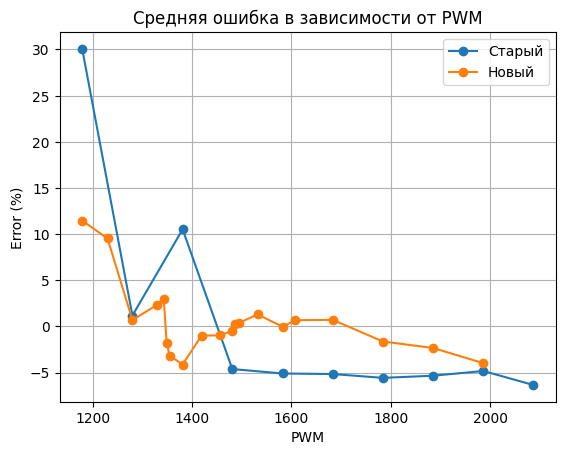

In [13]:
err_vs_pwm1 = analyzer1.per_test.groupby(['pwm'], as_index=False)['err_%'].mean().sort_values(by='pwm')
err_vs_pwm2 = analyzer2.per_test.groupby(['pwm'], as_index=False)['err_%'].mean().sort_values(by='pwm')

plt.plot(err_vs_pwm1['pwm'], err_vs_pwm1['err_%'], marker='o', label='Старый')
plt.plot(err_vs_pwm2['pwm'], err_vs_pwm2['err_%'], marker='o', label='Новый')

plt.xlabel('PWM')
plt.ylabel('Error (%)')
plt.title('Средняя ошибка в зависимости от PWM')
plt.legend()
plt.grid(True)
plt.show()

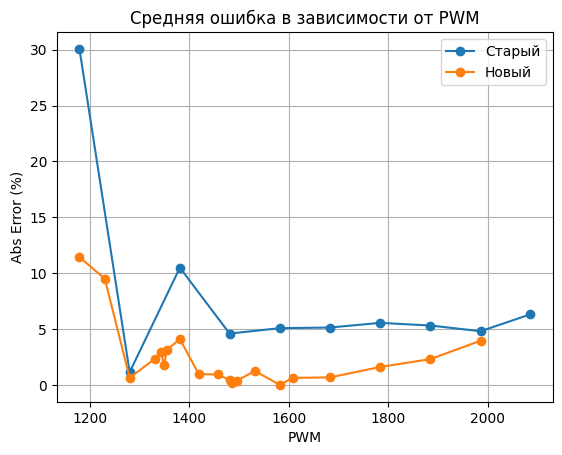

In [14]:
err_vs_pwm1 = analyzer1.per_test.groupby(['pwm'], as_index=False)['err_%'].mean().sort_values(by='pwm')
err_vs_pwm2 = analyzer2.per_test.groupby(['pwm'], as_index=False)['err_%'].mean().sort_values(by='pwm')

plt.plot(err_vs_pwm1['pwm'], abs(err_vs_pwm1['err_%']), marker='o', label='Старый')
plt.plot(err_vs_pwm2['pwm'], abs(err_vs_pwm2['err_%']), marker='o', label='Новый')

plt.xlabel('PWM')
plt.ylabel('Abs Error (%)')
plt.title('Средняя ошибка в зависимости от PWM')
plt.legend()
plt.grid(True)
plt.show()

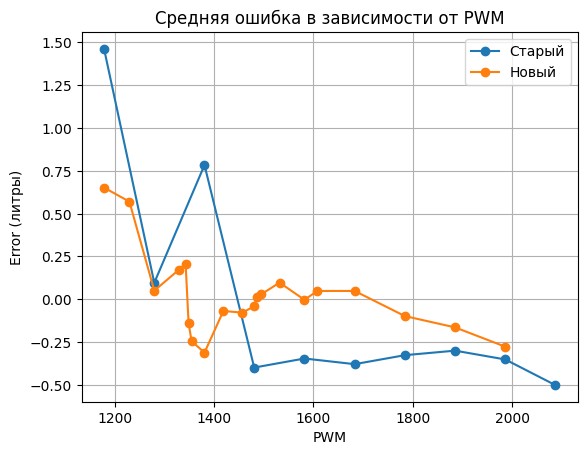

In [15]:
err_vs_pwm1 = analyzer1.per_test.groupby(['pwm'], as_index=False)['err_l'].mean().sort_values(by='pwm')
err_vs_pwm2 = analyzer2.per_test.groupby(['pwm'], as_index=False)['err_l'].mean().sort_values(by='pwm')

plt.plot(err_vs_pwm1['pwm'], err_vs_pwm1['err_l'], marker='o', label='Старый')
plt.plot(err_vs_pwm2['pwm'], err_vs_pwm2['err_l'], marker='o', label='Новый')

plt.xlabel('PWM')
plt.ylabel('Error (литры)')
plt.title('Средняя ошибка в зависимости от PWM')
plt.legend()
plt.grid(True)
plt.show()

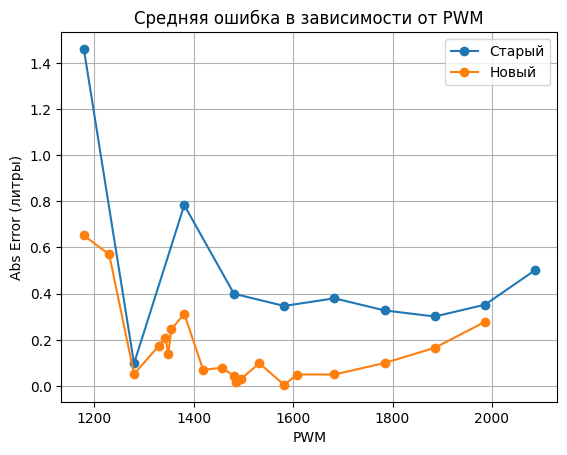

In [16]:
err_vs_pwm1 = analyzer1.per_test.groupby(['pwm'], as_index=False)['err_l'].mean().sort_values(by='pwm')
err_vs_pwm2 = analyzer2.per_test.groupby(['pwm'], as_index=False)['err_l'].mean().sort_values(by='pwm')

plt.plot(err_vs_pwm1['pwm'], abs(err_vs_pwm1['err_l']), marker='o', label='Старый')
plt.plot(err_vs_pwm2['pwm'], abs(err_vs_pwm2['err_l']), marker='o', label='Новый')

plt.xlabel('PWM')
plt.ylabel('Abs Error (литры)')
plt.title('Средняя ошибка в зависимости от PWM')
plt.legend()
plt.grid(True)
plt.show()

## Сравнение калибровочных коэффициентов

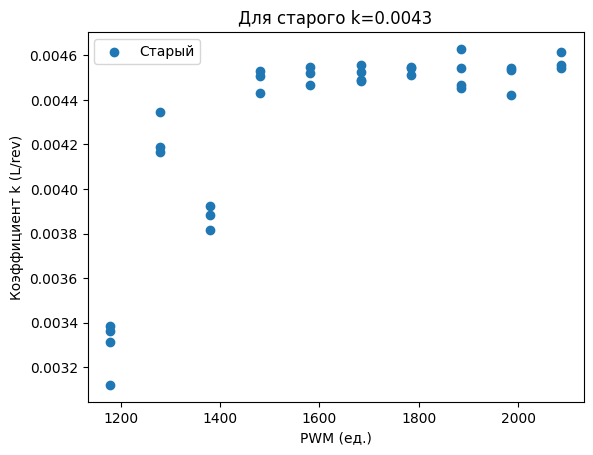

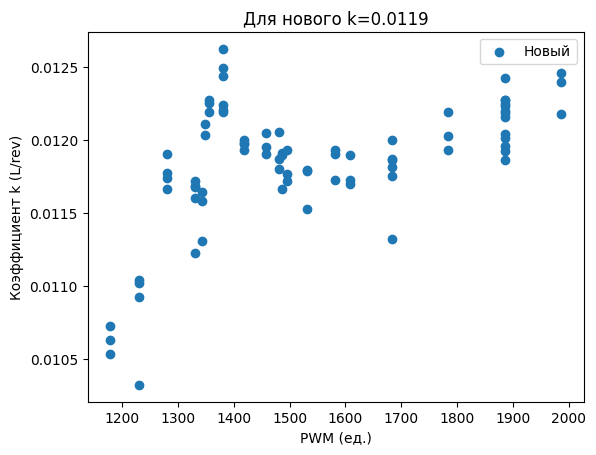

In [17]:
df_old = analyzer1.per_test
df_new = analyzer2.per_test

fig = plt.figure()
plt.scatter(df_old['pwm'], df_old['volume_fact_l'] / df_old['n_rev'] , label='Старый')

plt.xlabel("PWM (ед.)")
plt.ylabel("Коэффициент k (L/rev)")

plt.title(f"Для старого k={analyzer1.k_litre_per_rev:.4f}")
plt.legend()
plt.show()



fig = plt.figure()
plt.scatter(df_new['pwm'], df_new['volume_fact_l'] / df_new['n_rev'] , label='Новый')

plt.xlabel("PWM (ед.)")
plt.ylabel("Коэффициент k (L/rev)")

plt.title(f"Для нового k={analyzer2.k_litre_per_rev:.4f}")
plt.legend()
plt.show()

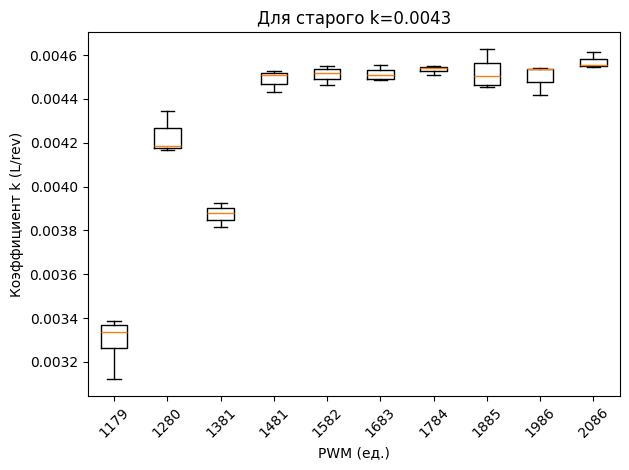

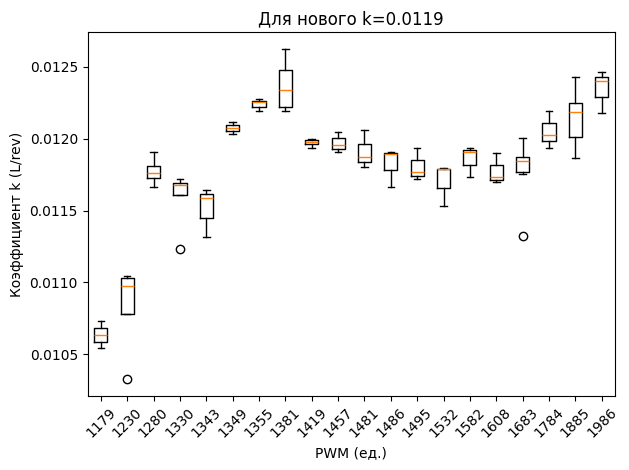

In [18]:
df_old = analyzer1.per_test
df_new = analyzer2.per_test

# Sort PWM lists
pwms_old = sorted(df_old['pwm'].unique())
pwms_new = sorted(df_new['pwm'].unique())

# Формируем данные для boxplot из TODO
data_old = [
    (df_old.loc[df_old['pwm'] == p, 'volume_fact_l'] / df_old.loc[df_old['pwm'] == p, 'n_rev']).values
    for p in pwms_old
]
data_new = [
    (df_new.loc[df_new['pwm'] == p, 'volume_fact_l'] / df_new.loc[df_new['pwm'] == p, 'n_rev']).values
    for p in pwms_new
]

# OLD
plt.figure()
plt.boxplot(data_old, tick_labels=[str(p) for p in pwms_old])
plt.xlabel("PWM (ед.)")
plt.ylabel("Коэффициент k (L/rev)")
plt.title(f"Для старого k={analyzer1.k_litre_per_rev:.4f}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# NEW
plt.figure()
plt.boxplot(data_new, tick_labels=[str(p) for p in pwms_new])
plt.xlabel("PWM (ед.)")
plt.ylabel("Коэффициент k (L/rev)")
plt.title(f"Для нового k={analyzer2.k_litre_per_rev:.4f}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Сравнение скорости работы насосов по pwm

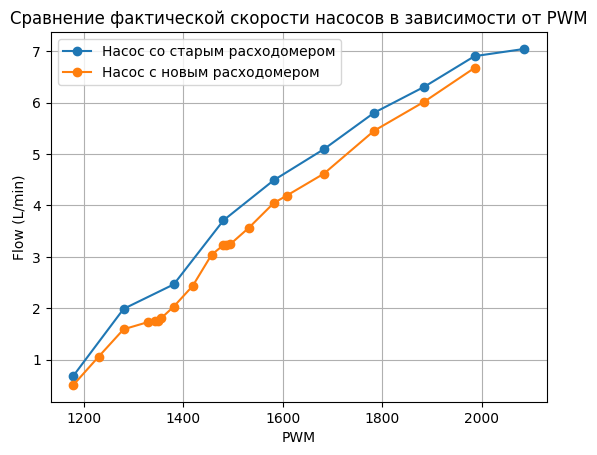

In [19]:
g1 = analyzer1.per_test.groupby(['pwm'], as_index=False)['flow_fact_lInMin'].mean().sort_values(by='pwm')
g2 = analyzer2.per_test.groupby(['pwm'], as_index=False)['flow_fact_lInMin'].mean().sort_values(by='pwm')

plt.plot(g1['pwm'], g1['flow_fact_lInMin'], marker='o', label='Насос со старым расходомером')
plt.plot(g2['pwm'], g2['flow_fact_lInMin'], marker='o', label='Насос с новым расходомером')

plt.xlabel('PWM')
plt.ylabel('Flow (L/min)')
plt.title('Сравнение фактической скорости насосов в зависимости от PWM')
plt.legend()
plt.grid(True)
plt.show()

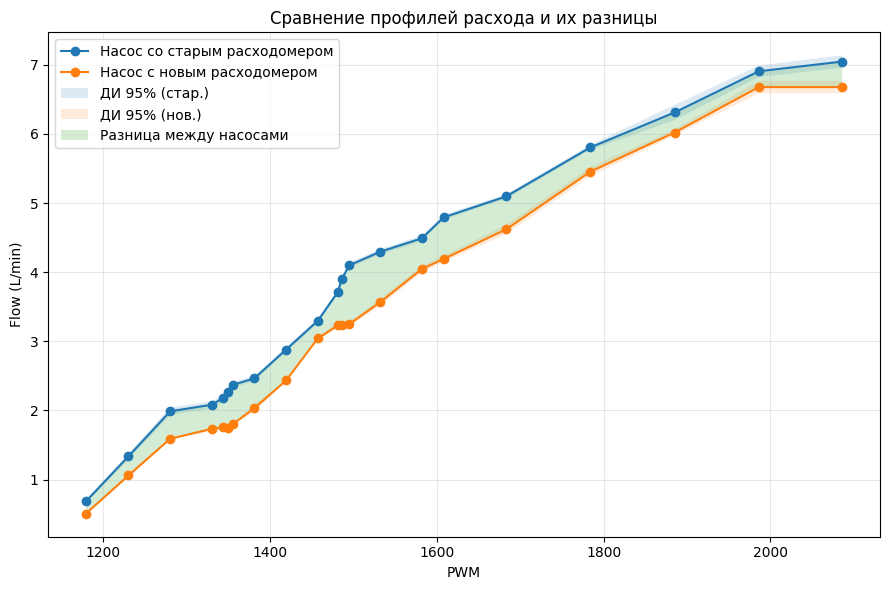

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Аггрегируем: среднее, std, n
g1 = (analyzer1.per_test
      .groupby('pwm')['flow_fact_lInMin']
      .agg(mean='mean', std='std', n='count')
      .reset_index())
g2 = (analyzer2.per_test
      .groupby('pwm')['flow_fact_lInMin']
      .agg(mean='mean', std='std', n='count')
      .reset_index())

# 2) Сетка PWM как объединение (если различаются)
pwm_grid = np.union1d(g1['pwm'].values, g2['pwm'].values)

# 3) Интерполяция на общую сетку (линейная; при одинаковых PWM просто совпадёт)
g1i = pd.DataFrame({'pwm': pwm_grid})
g2i = pd.DataFrame({'pwm': pwm_grid})

g1i = g1i.merge(g1, on='pwm', how='left').sort_values('pwm')
g2i = g2i.merge(g2, on='pwm', how='left').sort_values('pwm')

for col in ['mean', 'std', 'n']:
    g1i[col] = g1i[col].interpolate() if col in g1i else None
    g2i[col] = g2i[col].interpolate() if col in g2i else None


# 4) 95% ДИ (если есть std и n>1)
def ci95(std, n):
    return 1.96 * (std / np.sqrt(np.maximum(n, 1)))


g1_ci = ci95(g1i['std'], g1i['n']) if 'std' in g1i and 'n' in g1i else np.zeros_like(g1i['mean'])
g2_ci = ci95(g2i['std'], g2i['n']) if 'std' in g2i and 'n' in g2i else np.zeros_like(g2i['mean'])

# 5) Разница
delta = g2i['mean'] - g1i['mean']  # >0 — новый расходомер даёт больше поток
rel = delta / g1i['mean'] * 100.0  # относительная разница, %

plt.figure(figsize=(9, 6))
plt.plot(g1i['pwm'], g1i['mean'], marker='o', label='Насос со старым расходомером')
plt.plot(g2i['pwm'], g2i['mean'], marker='o', label='Насос с новым расходомером')

# ДИ (если есть)
if np.any(g1_ci > 0):
    plt.fill_between(g1i['pwm'], g1i['mean'] - g1_ci, g1i['mean'] + g1_ci, alpha=0.15, label='ДИ 95% (стар.)')
if np.any(g2_ci > 0):
    plt.fill_between(g2i['pwm'], g2i['mean'] - g2_ci, g2i['mean'] + g2_ci, alpha=0.15, label='ДИ 95% (нов.)')

# Полоса абсолютной разницы
plt.fill_between(g1i['pwm'], g1i['mean'], g2i['mean'], alpha=0.2, step=None, label='Разница между насосами')

plt.xlabel('PWM')
plt.ylabel('Flow (L/min)')
plt.title('Сравнение профилей расхода и их разницы')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


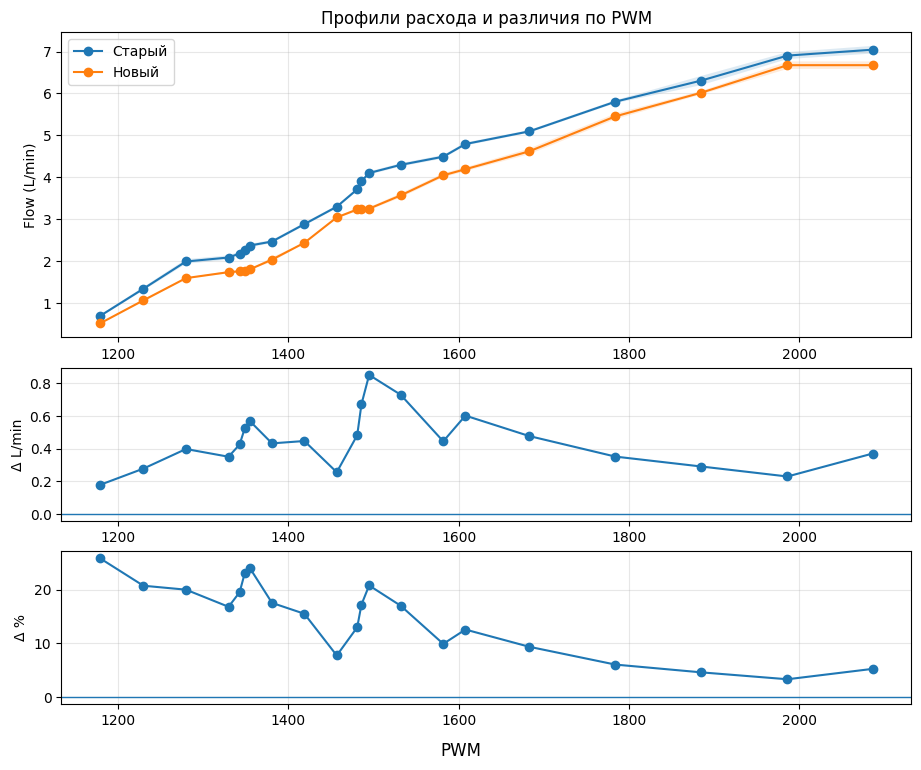

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(3, 1, height_ratios=[2, 1, 1], hspace=0.15)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)

# Верх: профили + ДИ
ax1.plot(g1i['pwm'], g1i['mean'], marker='o', label='Старый')
ax1.plot(g2i['pwm'], g2i['mean'], marker='o', label='Новый')
if np.any(g1_ci > 0):
    ax1.fill_between(g1i['pwm'], g1i['mean'] - g1_ci, g1i['mean'] + g1_ci, alpha=0.15)
if np.any(g2_ci > 0):
    ax1.fill_between(g2i['pwm'], g2i['mean'] - g2_ci, g2i['mean'] + g2_ci, alpha=0.15)
ax1.set_ylabel('Flow (L/min)')
ax1.set_title('Профили расхода и различия по PWM')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Середина: абсолютная разница
ax2.axhline(0, linewidth=1)
ax2.plot(g1i['pwm'], abs(g2i['mean'] - g1i['mean']), marker='o')
ax2.set_ylabel('Δ L/min')
ax2.grid(True, alpha=0.3)

# Низ: относительная разница
rel = (g2i['mean'] - g1i['mean']) / g1i['mean'] * 100.0
ax3.axhline(0, linewidth=1)
ax3.plot(g1i['pwm'], abs(rel), marker='o')
ax3.set_ylabel('Δ %')
ax3.grid(True, alpha=0.3)

# Общая подпись оси X
fig.supxlabel('PWM', fontsize=12)

# Настройка отступов вместо tight_layout
plt.subplots_adjust(left=0.1, right=0.95, top=0.92, bottom=0.08, hspace=0.15)

plt.show()

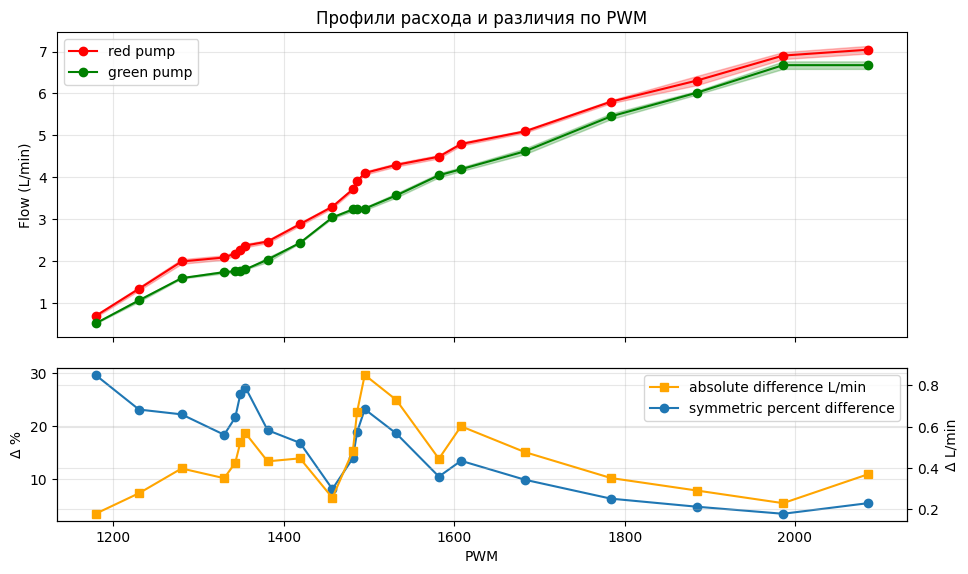

In [22]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(3, 1, height_ratios=[2, 1, 1], hspace=0.15)

ax1 = fig.add_subplot(gs[0, 0])
ax3 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax2 = ax3.twinx()

# профили
ax1.plot(g1i['pwm'], g1i['mean'], marker='o', label='red pump', color='red')
ax1.plot(g2i['pwm'], g2i['mean'], marker='o', label='green pump', color='green')

if np.any(g1_ci > 0):
    ax1.fill_between(g1i['pwm'], g1i['mean'] - g1_ci, g1i['mean'] + g1_ci, alpha=0.25, color='red')

if np.any(g2_ci > 0):
    ax1.fill_between(g2i['pwm'], g2i['mean'] - g2_ci, g2i['mean'] + g2_ci, alpha=0.25, color='green')

ax1.set_ylabel('Flow (L/min)')
ax1.set_title('Профили расхода и различия по PWM')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.tick_params(labelbottom=False)

# абсолютная разница
ax2.plot(g1i['pwm'], abs(g2i['mean'] - g1i['mean']), marker='s', label='absolute difference L/min', color='orange')
ax2.set_ylabel('Δ L/min')
ax2.grid(True, alpha=0.3)

# относительная разница
rel = abs(g2i['mean'] - g1i['mean']) / ((g2i['mean'] + g1i['mean']) / 2) * 100.0
ax3.plot(g1i['pwm'], rel, marker='o', label='symmetric percent difference')
ax3.set_ylabel('Δ %')
ax3.grid(True, alpha=0.3)
ax3.set_xlabel('PWM')


lines_1, labels_1 = ax2.get_legend_handles_labels()
lines_2, labels_2 = ax3.get_legend_handles_labels()
plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

# Общая подпись оси X
plt.subplots_adjust(left=0.1, right=0.95, top=0.92, bottom=0.08, hspace=0.15)
plt.show()

In [23]:
import numpy as np
from sklearn.linear_model import LinearRegression

# 1. Объединяем данные и берём среднее по двум насосам
pwm_all = np.concatenate([g1i['pwm'], g2i['pwm']])
flow_all = np.concatenate([(g1i['mean'] + g2i['mean']) / 2,
                           (g1i['mean'] + g2i['mean']) / 2])

# 2. Линейная регрессия
model = LinearRegression()
model.fit(pwm_all.reshape(-1, 1), flow_all)

# коэффициенты
k = model.coef_[0]     # наклон
b = model.intercept_   # сдвиг

print(f"Модель: Flow = {k:.4f} * PWM + {b:.4f}")

# 3. Предсказание
pwm_range = np.linspace(min(pwm_all), max(pwm_all), 100)
flow_pred = model.predict(pwm_range.reshape(-1, 1))

# 4. Добавление на график
ax1.plot(pwm_range, flow_pred, '--', color='blue', label='approximation (linear fit)')
ax1.legend()



Модель: Flow = 0.0073 * PWM + -7.6001


[AVG-FIT] Flow = 0.007295 * PWM + -7.600139
ШИМ для одного насоса:


Eq(PWM, 137.075962546903*Flow + 1041.79637446836)

ШИМ для обоих сразу насоса:


Eq(PWM, 68.5379812734516*Flow + 1041.79637446836)

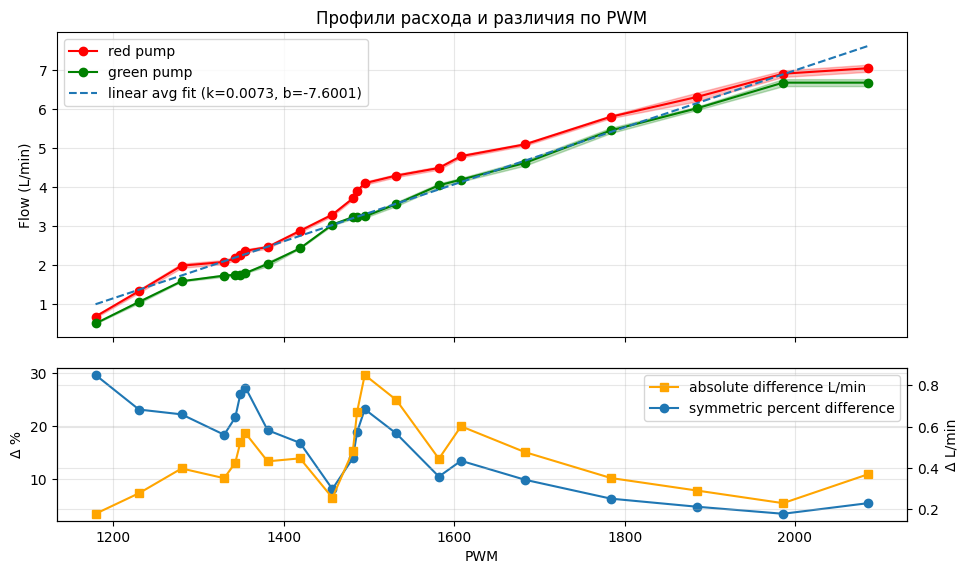

In [24]:
from sympy import Eq
# -*- coding: utf-8 -*-
# Полный код построения графика и линейной аппроксимации PWM -> L/min
# Основано на: предоставленной разметке графиков и идее линейной регрессии по объединённым данным.
# Предполагается, что g1i, g2i — pandas.DataFrame с колонками 'pwm', 'mean'
# а g1_ci, g2_ci — массивы/Series таких же длин, как соответствующие 'mean' (опционально).
from sympy import symbols, simplify

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==========================
# НАСТРОЙКИ
# ==========================
DO_FIT_AVG = True         # линия по среднему профилю
DO_FIT_COMBINED = False    # линия по обеим кривым сразу
SAVE_FIG = False
FIG_NAME = 'pwm_flow_with_fits.png'

# ==========================
# ВСПОМОГАТЕЛЬНЫЕ ФУНКЦИИ
# ==========================
def _ensure_numeric(series, name):
    s = pd.to_numeric(series, errors='coerce')
    if s.isna().any():
        raise ValueError(f"Колонка '{name}' содержит NaN/нечисловые значения после приведения типов.")
    return s

def align_on_pwm(g1i: pd.DataFrame, g2i: pd.DataFrame):
    """
    Возвращает объединённый по общим PWM датафрейм:
    columns: pwm, mean_g1, mean_g2
    Если сетки PWM различаются, берём пересечение (inner join).
    """
    need_cols = {'pwm', 'mean'}
    if not need_cols.issubset(g1i.columns) or not need_cols.issubset(g2i.columns):
        raise ValueError("Ожидаются колонки 'pwm' и 'mean' в g1i и g2i.")

    df1 = g1i[['pwm', 'mean']].copy()
    df2 = g2i[['pwm', 'mean']].copy()

    df1['pwm']  = _ensure_numeric(df1['pwm'], 'g1i.pwm')
    df1['mean'] = _ensure_numeric(df1['mean'], 'g1i.mean')
    df2['pwm']  = _ensure_numeric(df2['pwm'], 'g2i.pwm')
    df2['mean'] = _ensure_numeric(df2['mean'], 'g2i.mean')

    # Удаляем потенциальные дубликаты PWM, оставляя среднее по дубликатам
    df1 = df1.groupby('pwm', as_index=False)['mean'].mean()
    df2 = df2.groupby('pwm', as_index=False)['mean'].mean()

    merged = pd.merge(df1, df2, on='pwm', how='inner', suffixes=('_g1', '_g2'))
    if merged.empty:
        raise ValueError("Нет пересечения по PWM между g1i и g2i.")
    return merged.sort_values('pwm').reset_index(drop=True)

def fit_linear(x, y, w=None):
    """
    Взвешенная линейная регрессия y ~ k*x + b.
    x, y — 1D numpy arrays одинаковой длины.
    w — веса (опционально), такой же длины.
    Возвращает (k, b).
    """
    x = np.asarray(x, dtype=float).ravel()
    y = np.asarray(y, dtype=float).ravel()
    if x.size != y.size:
        raise ValueError("Длины x и y не совпадают.")
    if w is None:
        # Невзвешенный случай — через polyfit степени 1
        k, b = np.polyfit(x, y, 1)
        return float(k), float(b)
    else:
        w = np.asarray(w, dtype=float).ravel()
        if w.size != x.size:
            raise ValueError("Длины весов w и данных не совпадают.")
        X = np.column_stack([x, np.ones_like(x)])
        # Решаем (X^T W X) theta = X^T W y
        W = np.diag(w)
        XT_W = X.T @ W
        theta = np.linalg.solve(XT_W @ X, XT_W @ y)
        k, b = theta[0], theta[1]
        return float(k), float(b)

def predict_line(k, b, x_grid):
    xg = np.asarray(x_grid, dtype=float)
    return k * xg + b

def safe_ci(ci, n_expected):
    """
    Возвращает массив CI длины n_expected или None.
    Если ci отсутствует или длина не совпадает — вернём None.
    """
    if ci is None:
        return None
    ci_arr = np.asarray(ci, dtype=float).ravel()
    if ci_arr.size != n_expected:
        return None
    return ci_arr

# ==========================
# ОСНОВНОЙ ПАЙПЛАЙН
# ==========================
def build_and_plot(g1i: pd.DataFrame, g2i: pd.DataFrame,
                   g1_ci=None, g2_ci=None,
                   do_fit_avg=True, do_fit_combined=True,
                   save_fig=True, fig_name='pwm_flow_with_fits.png'):
    merged = align_on_pwm(g1i, g2i)
    pwm = merged['pwm'].to_numpy()
    mean_g1 = merged['mean_g1'].to_numpy()
    mean_g2 = merged['mean_g2'].to_numpy()

    # CI подгоняем к пересечению сеток (если их давали в исходной сетке)
    # Поскольку мы делали inner-join, индексы старых фреймов не соответствуют merged.
    # Поэтому CI корректно нарисовать можно только если они уже соответствуют merged.
    # Для надёжности — не используем CI, если длина не совпадает.
    ci1 = safe_ci(g1_ci, len(merged))
    ci2 = safe_ci(g2_ci, len(merged))

    # Подготовка графиков
    fig = plt.figure(figsize=(10, 8))
    gs = fig.add_gridspec(3, 1, height_ratios=[2, 1, 1], hspace=0.15)

    ax1 = fig.add_subplot(gs[0, 0])
    ax3 = fig.add_subplot(gs[1, 0], sharex=ax1)
    ax2 = ax3.twinx()

    # Профили
    ax1.plot(pwm, mean_g1, marker='o', label='red pump', color='red')
    ax1.plot(pwm, mean_g2, marker='o', label='green pump', color='green')

    if ci1 is not None and np.any(ci1 > 0):
        ax1.fill_between(pwm, mean_g1 - ci1, mean_g1 + ci1, alpha=0.25, color='red')
    if ci2 is not None and np.any(ci2 > 0):
        ax1.fill_between(pwm, mean_g2 - ci2, mean_g2 + ci2, alpha=0.25, color='green')

    ax1.set_ylabel('Flow (L/min)')
    ax1.set_title('Профили расхода и различия по PWM')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.tick_params(labelbottom=False)

    # Абсолютная разница
    abs_diff = np.abs(mean_g2 - mean_g1)
    ax2.plot(pwm, abs_diff, marker='s', label='absolute difference L/min', color='orange')
    ax2.set_ylabel('Δ L/min')
    ax2.grid(True, alpha=0.3)

    # Относительная (симметричная) разница
    rel = abs_diff / ((mean_g2 + mean_g1) / 2.0) * 100.0
    ax3.plot(pwm, rel, marker='o', label='symmetric percent difference')
    ax3.set_ylabel('Δ %')
    ax3.grid(True, alpha=0.3)
    ax3.set_xlabel('PWM')

    # ЛЕГЕНДА НИЖНИХ ГРАФИКОВ
    lines_1, labels_1 = ax2.get_legend_handles_labels()
    lines_2, labels_2 = ax3.get_legend_handles_labels()
    ax3.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

    # ==========================
    # ЛИНЕЙНЫЕ АППРОКСИМАЦИИ
    # ==========================
    x_grid = np.linspace(pwm.min(), pwm.max(), 200)

    if do_fit_avg:
        y_avg = (mean_g1 + mean_g2) / 2.0
        k_avg, b_avg = fit_linear(pwm, y_avg)
        y_pred_avg = predict_line(k_avg, b_avg, x_grid)
        ax1.plot(x_grid, y_pred_avg, '--', label=f'linear avg fit (k={k_avg:.4f}, b={b_avg:.4f})')
        print(f"[AVG-FIT] Flow = {k_avg:.6f} * PWM + {b_avg:.6f}")

        # Символы
        Flow, k_avg_s, b_avg_s, pwm = symbols('Flow k_avg b_avg PWM')

        # Исходное выражение
        expr = (Flow + (-b_avg_s)) / k_avg_s
        expr_simplified = simplify(expr)
        equation = Eq(pwm, expr_simplified)

        print('ШИМ для одного насоса:')
        display(equation.subs({k_avg_s: k_avg, b_avg_s: b_avg}))

        expr = (Flow / 2 + (-b_avg_s)) / k_avg_s
        expr_simplified = simplify(expr)
        equation = Eq(pwm, expr_simplified)

        print('ШИМ для обоих сразу насоса:')
        display(equation.subs({k_avg_s: k_avg, b_avg_s: b_avg}))


    if do_fit_combined:
        # Дублируем x, объединяем y обоих насосов
        x_comb = np.concatenate([pwm, pwm])
        y_comb = np.concatenate([mean_g1, mean_g2])
        k_cmb, b_cmb = fit_linear(x_comb, y_comb)
        y_pred_cmb = predict_line(k_cmb, b_cmb, x_grid)
        ax1.plot(x_grid, y_pred_cmb, ':', label=f'linear combined fit (k={k_cmb:.4f}, b={b_cmb:.4f})')
        print(f"[COMBINED-FIT] Flow = {k_cmb:.6f} * PWM + {b_cmb:.6f}")

    ax1.legend()
    plt.subplots_adjust(left=0.1, right=0.95, top=0.92, bottom=0.08, hspace=0.15)

    if save_fig:
        plt.savefig(fig_name, dpi=150)
        print(f"Saved figure: {fig_name}")

    plt.show()

# ==========================
# ПРИМЕР ВЫЗОВА
# ==========================
build_and_plot(g1i, g2i, g1_ci=g1_ci, g2_ci=g2_ci,
               do_fit_avg=DO_FIT_AVG, do_fit_combined=DO_FIT_COMBINED,
               save_fig=SAVE_FIG, fig_name=FIG_NAME)

## Сравнение ошибок

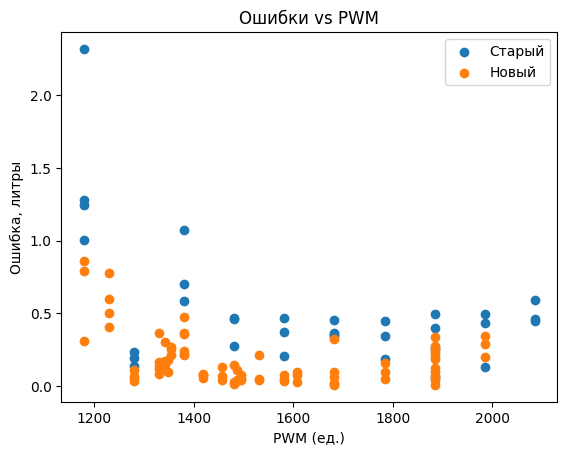

In [25]:
df_old = analyzer1.per_test
df_new = analyzer2.per_test

fig = plt.figure()
plt.scatter(df_old['pwm'], abs(df_old['err_l']), label='Старый')
plt.scatter(df_new['pwm'], abs(df_new['err_l']), label='Новый')

plt.xlabel("PWM (ед.)")
plt.ylabel("Ошибка, литры")

plt.title("Ошибки vs PWM")
plt.legend()
plt.show()

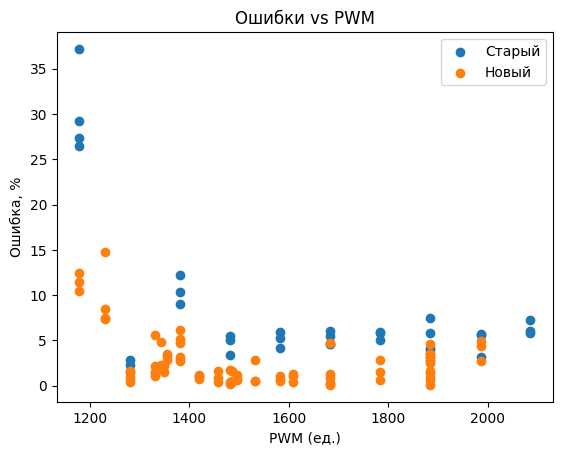

In [26]:
df_old = analyzer1.per_test
df_new = analyzer2.per_test

fig = plt.figure()
plt.scatter(df_old['pwm'], abs(df_old['err_%']), label='Старый')
plt.scatter(df_new['pwm'], abs(df_new['err_%']), label='Новый')

plt.xlabel("PWM (ед.)")
plt.ylabel("Ошибка, %")

plt.title("Ошибки vs PWM")
plt.legend()
plt.show()

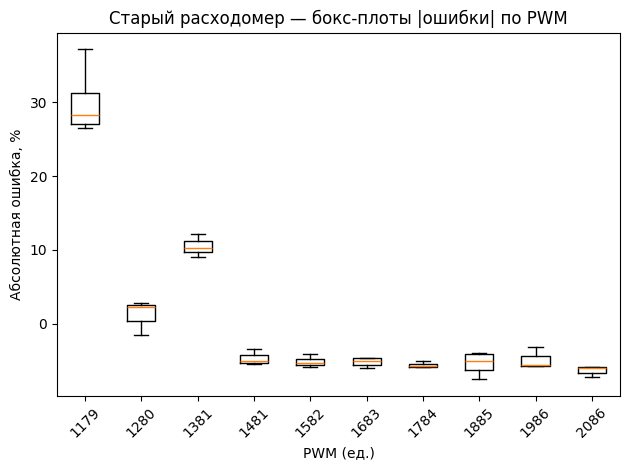

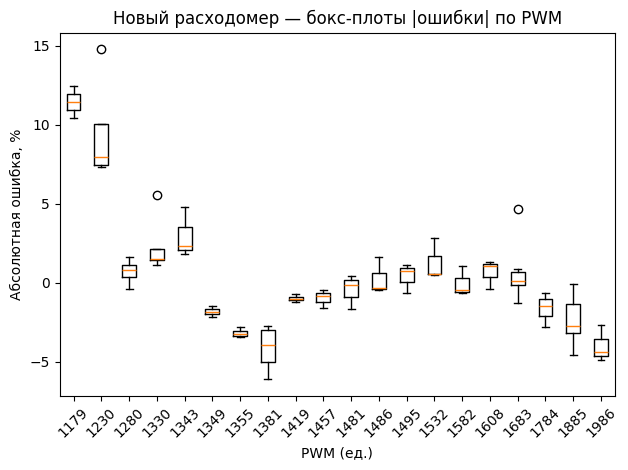

In [27]:
data_old = analyzer1.per_test
data_new = analyzer2.per_test

# Sort PWM lists
pwms_old = sorted(df_old['pwm'].unique())
pwms_new = sorted(df_new['pwm'].unique())

# Group to lists for boxplot
data_old = [df_old.loc[df_old['pwm']==p, 'err_%'].values for p in pwms_old]
data_new = [df_new.loc[df_new['pwm']==p, 'err_%'].values for p in pwms_new]


# OLD
plt.figure()
plt.boxplot(data_old, tick_labels=[str(p) for p in pwms_old])
plt.xlabel("PWM (ед.)")
plt.ylabel("Абсолютная ошибка, %")
plt.title("Старый расходомер — бокс-плоты |ошибки| по PWM")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# NEW
plt.figure()
plt.boxplot(data_new, tick_labels=[str(p) for p in pwms_new])
plt.xlabel("PWM (ед.)")
plt.ylabel("Абсолютная ошибка, %")
plt.title("Новый расходомер — бокс-плоты |ошибки| по PWM")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

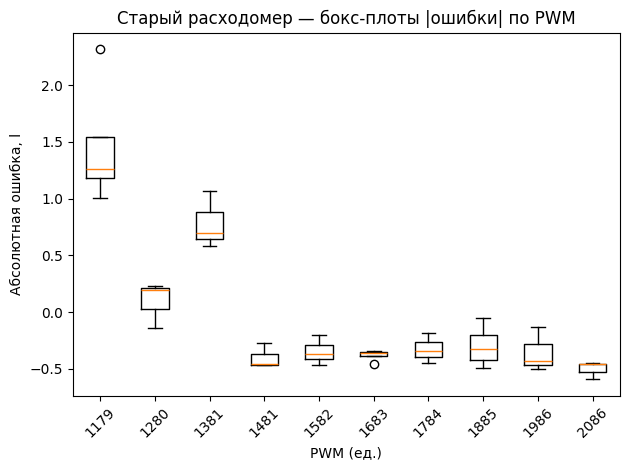

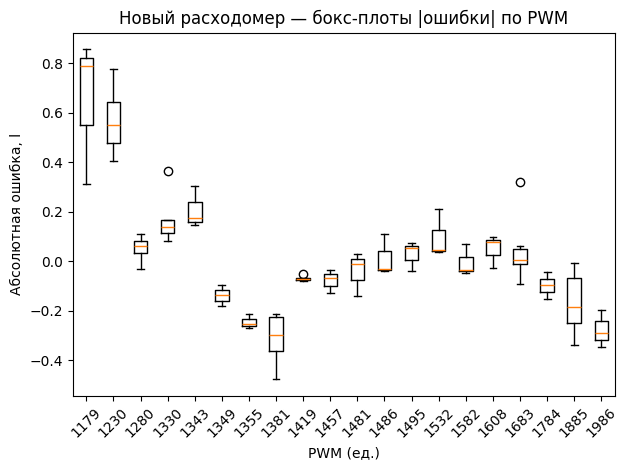

In [28]:
data_old = analyzer1.per_test
data_new = analyzer2.per_test

# Sort PWM lists
pwms_old = sorted(df_old['pwm'].unique())
pwms_new = sorted(df_new['pwm'].unique())

# Group to lists for boxplot
data_old = [df_old.loc[df_old['pwm']==p, 'err_l'].values for p in pwms_old]
data_new = [df_new.loc[df_new['pwm']==p, 'err_l'].values for p in pwms_new]


# OLD
plt.figure()
plt.boxplot(data_old, tick_labels=[str(p) for p in pwms_old])
plt.xlabel("PWM (ед.)")
plt.ylabel("Абсолютная ошибка, l")
plt.title("Старый расходомер — бокс-плоты |ошибки| по PWM")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# NEW
plt.figure()
plt.boxplot(data_new, tick_labels=[str(p) for p in pwms_new])
plt.xlabel("PWM (ед.)")
plt.ylabel("Абсолютная ошибка, l")
plt.title("Новый расходомер — бокс-плоты |ошибки| по PWM")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Комбинированные графики

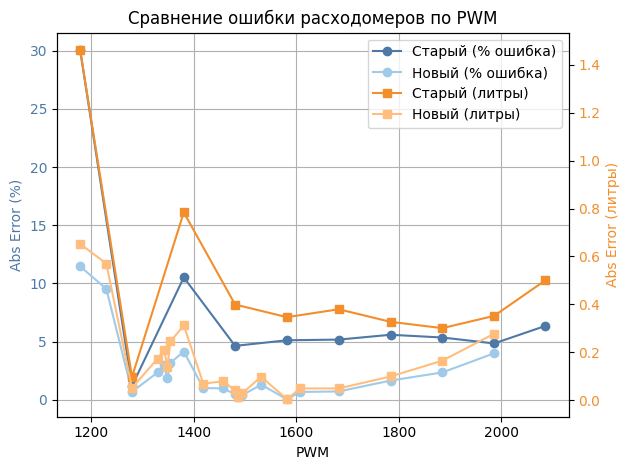

In [29]:
import matplotlib.pyplot as plt

# Подготовка данных
err_pct1 = analyzer1.per_test.groupby('pwm', as_index=False)['err_%'].mean().sort_values(by='pwm')
err_pct2 = analyzer2.per_test.groupby('pwm', as_index=False)['err_%'].mean().sort_values(by='pwm')

err_lit1 = analyzer1.per_test.groupby('pwm', as_index=False)['err_l'].mean().sort_values(by='pwm')
err_lit2 = analyzer2.per_test.groupby('pwm', as_index=False)['err_l'].mean().sort_values(by='pwm')

# Цвета из стандартной палитры matplotlib
colors = {
    'err_pct_old': '#4E79A7',  # тёмно-синий
    'err_pct_new': '#A0CBE8',  # светло-синий
    'err_lit_old': '#F28E2B',  # оранжевый
    'err_lit_new': '#FFBE7D',  # светло-оранжевый
}

# Основной график
fig, ax1 = plt.subplots()

# Левая ось — относительная ошибка (%)
ax1.plot(err_pct1['pwm'], abs(err_pct1['err_%']), marker='o',
         label='Старый (% ошибка)', color=colors['err_pct_old'])
ax1.plot(err_pct2['pwm'], abs(err_pct2['err_%']), marker='o',
         label='Новый (% ошибка)', color=colors['err_pct_new'])
ax1.set_xlabel('PWM')
ax1.set_ylabel('Abs Error (%)', color=colors['err_pct_old'])
ax1.tick_params(axis='y', labelcolor=colors['err_pct_old'])
ax1.grid(True)

# Правая ось — абсолютная ошибка (литры)
ax2 = ax1.twinx()
ax2.plot(err_lit1['pwm'], abs(err_lit1['err_l']), marker='s',
         label='Старый (литры)', color=colors['err_lit_old'])
ax2.plot(err_lit2['pwm'], abs(err_lit2['err_l']), marker='s',
         label='Новый (литры)', color=colors['err_lit_new'])
ax2.set_ylabel('Abs Error (литры)', color=colors['err_lit_old'])
ax2.tick_params(axis='y', labelcolor=colors['err_lit_old'])

# Легенда
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.title('Сравнение ошибки расходомеров по PWM')
plt.tight_layout()
plt.savefig(fname='g_abs.png', dpi=400)
plt.show()


 ## Сравнительная таблица

In [30]:
data = {
    "MAE (л)": [
        analyzer1.overall_mae(),
        analyzer2.overall_mae()
    ],
    "MAPE (%)": [
        analyzer1.overall_mape(),
        analyzer2.overall_mape()
    ],
    "RMSE (л)": [
        analyzer1.overall_rmse(),
        analyzer2.overall_rmse()
    ],
    "SMAPE (%)": [
        analyzer1.overall_smape(),
        analyzer2.overall_smape()
    ]
}

df_comparison = pd.DataFrame(data, index=["Старый", "Новый"])


In [31]:
df_comparison

,MAE (л),MAPE (%),RMSE (л),SMAPE (%)
Старый,0.523186,7.666535,0.675134,8.050077
Новый,0.176045,2.493290,0.247915,2.618803


In [32]:
analyzer1.per_test

,test_id,duration_s,pwm,volume_fact_l,volume_meas_l,err_l,err_%,flow_fact_lInMin,flow_meas_lInMin,n_rev
0,1,68.802,2086,8.18524,7.593813,-0.591427,-7.225526,7.138083,6.622319,1773.705382
1,2,68.083,2086,7.93569,7.475375,-0.460315,-5.800573,6.993543,6.587878,1746.041328
2,3,64.126,2086,7.48650,7.037004,-0.449496,-6.004084,7.004803,6.584229,1643.650134
3,4,74.751,1986,8.63443,8.137160,-0.497270,-5.759150,6.930553,6.531412,1900.616216
4,5,66.242,1986,7.68614,7.255641,-0.430499,-5.600980,6.961873,6.571940,1694.717597
5,6,35.557,1986,4.04271,3.915664,-0.127046,-3.142587,6.821796,6.607415,914.591203
6,7,58.395,1885,6.08902,5.833158,-0.255862,-4.202025,6.256378,5.993484,1362.464809
7,8,65.781,1885,6.93749,6.537582,-0.399908,-5.764444,6.327806,5.963043,1526.998922
8,9,61.217,1885,6.58812,6.093410,-0.494710,-7.509124,6.457148,5.972272,1423.252511
9,10,12.566,1885,1.29766,1.247056,-0.050604,-3.899643,6.196053,5.954429,291.277866


In [33]:
analyzer2.per_test

,test_id,duration_s,pwm,volume_fact_l,volume_meas_l,err_l,err_%,flow_fact_lInMin,flow_meas_lInMin,n_rev
0,1,59.614,1986,6.58812,6.298341,-0.289779,-4.398505,6.630778,6.339123,531.360109
1,2,62.832,1986,7.08722,6.740998,-0.346222,-4.885161,6.767781,6.437164,568.704879
2,3,65.947,1986,7.28686,7.091784,-0.195076,-2.677093,6.629742,6.452258,598.298979
3,4,70.664,1885,7.18704,6.937780,-0.249260,-3.468184,6.102434,5.890790,585.306440
4,5,72.351,1885,7.18704,7.121274,-0.065766,-0.915064,5.960144,5.905605,600.786904
...,...,...,...,...,...,...,...,...,...,...
75,76,277.235,1343,8.13533,8.281213,0.145883,1.793207,1.760672,1.792244,698.645289
76,77,218.268,1349,6.38848,6.292374,-0.096106,-1.504370,1.756138,1.729720,530.856656
77,78,288.441,1349,8.38488,8.204452,-0.180428,-2.151830,1.744179,1.706647,692.169284
78,79,22.411,1885,2.24595,2.181684,-0.064266,-2.861410,6.012985,5.840929,184.057976
